In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

__file__ = "/leonardo_work/EUHPC_D12_053/stgcn-distributed/script/analyze_error_csv.py"

script_dir = os.path.dirname(os.path.abspath(__file__))
base_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

In [2]:
csv_file = "2025-02-26_11-36-36_pems-bay_pred-60min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric/delta.csv"

path = os.path.join(base_dir, 'logs', csv_file)
print(f"Processing: {path}")

df = pd.read_csv(path, header=None)  # Assuming no headers
print(f"Global average: {df.values.mean()}")
df = df.T

# df = df.iloc[:10,:100]
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

df_long = df.melt(value_vars=df.columns, ignore_index=False)
df_long = df_long.reset_index()
df_long = df_long.rename(columns={"index": "sensorId", "variable": "timestep", "value": "predictionDelta"})

Processing: /leonardo_work/EUHPC_D12_053/stgcn-distributed/logs/2025-02-26_11-36-36_pems-bay_pred-60min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric/delta.csv
Global average: -0.34815166432082145
Rows: 325, Columns: 7793


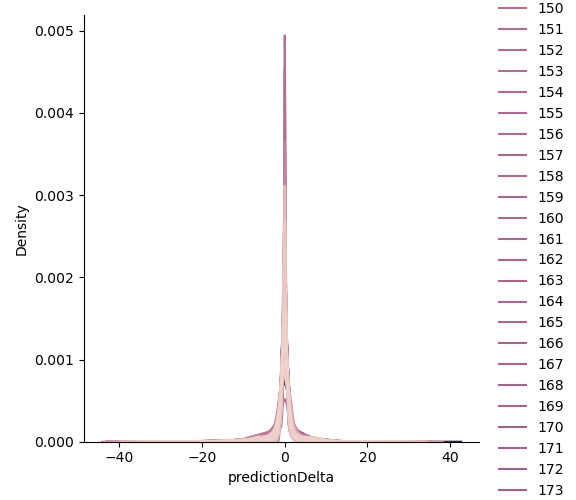

In [3]:
plt.close()
sns.displot(data=df_long, x="predictionDelta", hue="sensorId", kind="kde")

In [4]:
# Count how many predictionDelta values are between -0.5 and 0.5 for each sensor
df_sensor_count = df_long[(df_long["predictionDelta"] >= -0.5) & (df_long["predictionDelta"] <= 0.5)]
df_sensor_count = df_sensor_count.groupby("sensorId")["predictionDelta"].count()

# Sort by highest count and get top 5 sensors
df_sensor_count = df_sensor_count.sort_values(ascending=True).head(5)

# Print results
for sensor_id, count in df_sensor_count.items():
    print(f"Sensor {sensor_id}: Count of predictionDelta = {count}")

Sensor 133: Count of predictionDelta = 1603
Sensor 134: Count of predictionDelta = 1941
Sensor 320: Count of predictionDelta = 2130
Sensor 74: Count of predictionDelta = 2266
Sensor 283: Count of predictionDelta = 2451


In [5]:
# Count how many predictionDelta values are between -6 and -3 for each sensor
df_sensor_count = df_long[(df_long["predictionDelta"] >= -6) & (df_long["predictionDelta"] <= -3)]
df_sensor_count = df_sensor_count.groupby("sensorId")["predictionDelta"].count()

# Sort by highest count and get top 20 sensors
df_sensor_count = df_sensor_count.sort_values(ascending=False).head(9)

# Print results
for sensor_id, count in df_sensor_count.items():
    print(f"Sensor {sensor_id}: Count of predictionDelta between -6 and -3 = {count}")

Sensor 134: Count of predictionDelta between -6 and -3 = 845
Sensor 133: Count of predictionDelta between -6 and -3 = 772
Sensor 231: Count of predictionDelta between -6 and -3 = 652
Sensor 320: Count of predictionDelta between -6 and -3 = 618
Sensor 254: Count of predictionDelta between -6 and -3 = 618
Sensor 268: Count of predictionDelta between -6 and -3 = 587
Sensor 283: Count of predictionDelta between -6 and -3 = 583
Sensor 293: Count of predictionDelta between -6 and -3 = 569
Sensor 38: Count of predictionDelta between -6 and -3 = 560


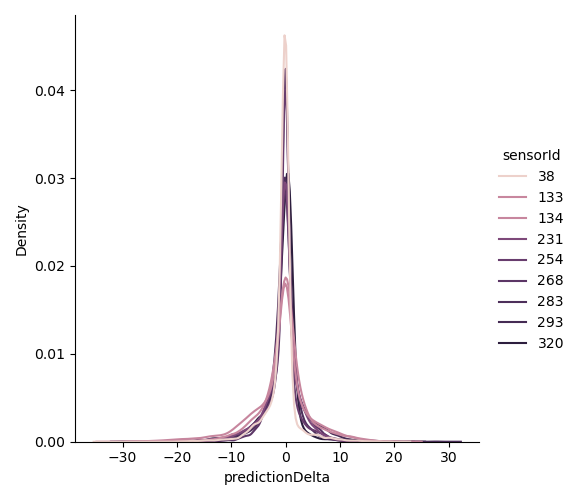

In [6]:
top_sensors = df_sensor_count.index.tolist()
# top_sensors = [133]

# Filter the original dataframe to keep only these sensors
df_filtered = df_long[df_long["sensorId"].isin(top_sensors)]


plt.close()
sns.displot(data=df_filtered, x="predictionDelta", hue="sensorId", kind="kde")

<Axes: xlabel='timestep', ylabel='predictionDelta'>

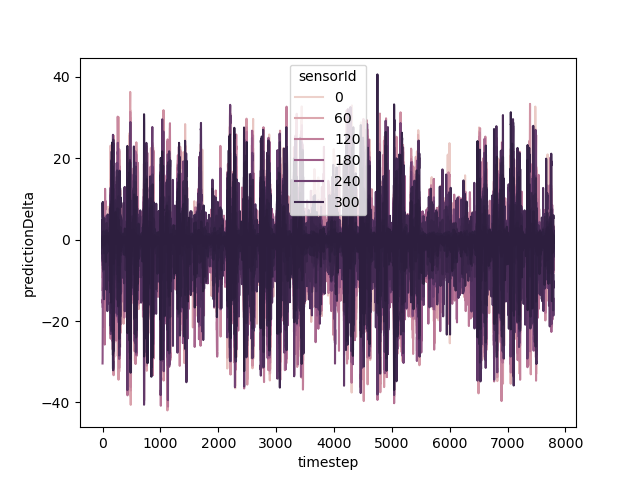

In [7]:
plt.close()
sns.lineplot(data=df_long, y="predictionDelta", x="timestep", hue="sensorId")

In [5]:
df_long.predictionDelta.mean()

-0.34815166432082145

In [13]:
df_long_rolling = df_long.groupby('sensorId').rolling(12, on="timestep").mean()
df_long_rolling.head(20)

timestep  abs_predictionDelta  predictionDelta
sensorId                                                     
0        0            0                  NaN              NaN
         207          1                  NaN              NaN
         414          2                  NaN              NaN
         621          3                  NaN              NaN
         828          4                  NaN              NaN
         1035         5                  NaN              NaN
         1242         6                  NaN              NaN
         1449         7                  NaN              NaN
         1656         8                  NaN              NaN
         1863         9                  NaN              NaN
         2070        10                  NaN              NaN
         2277        11             0.816115         0.445148
         2484        12             0.730586         0.359619
         2691        13             0.668690         0.260751
         2898        14             0.597468         0.181852
         3105        15             0.540198         0.124581
         3312        16             0.497270         0.226923
         3519        17             0.415147         0.133716
         3726        18             0.372407         0.090975
         3933        19             0.327406         0.045974

In [6]:
df_low_error = df_long.groupby("timestep")["predictionDelta"].mean()
df_low_error = df_low_error[df_low_error < df_low_error.quantile(0.05)]  # Bottom 5% lowest errors
df_low_error.sort_values(ascending=True)  # Sort from lowest to highest

timestep
4323   -4.665679
289    -4.622937
290    -4.600423
4324   -4.486493
4322   -4.462486
          ...   
2459   -1.702897
2786   -1.698524
1149   -1.698123
6890   -1.697766
766    -1.694893
Name: predictionDelta, Length: 390, dtype: float64

In [7]:
df_sensor_error = df_long.groupby("sensorId")["predictionDelta"].mean()

# Filter only negative values (cases where original is better)
df_sensor_error = df_sensor_error[df_sensor_error < 0]

# Sort from most negative (largest error difference) to least negative
df_sensor_error = df_sensor_error.sort_values(ascending=True)

for sensor_id, error in df_sensor_error.items():
    print(f"Sensor {sensor_id}: Average Prediction Delta = {error:.4f}")

Sensor 201: Average Prediction Delta = -1.3352
Sensor 235: Average Prediction Delta = -1.2482
Sensor 81: Average Prediction Delta = -1.2075
Sensor 109: Average Prediction Delta = -1.1946
Sensor 135: Average Prediction Delta = -1.1700
Sensor 141: Average Prediction Delta = -1.1614
Sensor 9: Average Prediction Delta = -1.1145
Sensor 275: Average Prediction Delta = -1.0770
Sensor 56: Average Prediction Delta = -1.0507
Sensor 17: Average Prediction Delta = -1.0388
Sensor 134: Average Prediction Delta = -1.0237
Sensor 127: Average Prediction Delta = -1.0235
Sensor 203: Average Prediction Delta = -1.0190
Sensor 114: Average Prediction Delta = -1.0080
Sensor 6: Average Prediction Delta = -0.9786
Sensor 15: Average Prediction Delta = -0.9649
Sensor 276: Average Prediction Delta = -0.9616
Sensor 257: Average Prediction Delta = -0.9549
Sensor 96: Average Prediction Delta = -0.9529
Sensor 217: Average Prediction Delta = -0.9461
Sensor 99: Average Prediction Delta = -0.9437
Sensor 279: Average Pre